<a href="https://colab.research.google.com/github/jpdeleon/chronos/blob/master/notebooks/examples-lightcurves-tess-pathos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install git+https://github.com/jpdeleon/chronos.git@master

In [2]:
%matplotlib inline
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [10]:
p = cr.PATHOS(toiid=837, lctype="corr", aper_idx=4)

Target: TOI 837
Using PATHOS lightcurve.
Available sectors: [10 11]
PATHOS lc may be available for sectors [10 11]
Using sector=10.
Querying Gaia DR2 catalog for ra,dec=(157.037 -64.5052) within 3.0 arcsec.
There are 2 gaia sources within 3.0 arcsec.
High proper-motion star:
(pmra,pmdec)=(-18.02,11.31) mas/yr
Querying TIC catalog for ra,dec=(157.037 -64.5052) within 3.0 arcsec.
There are 2 TIC stars within 3.0 arcsec
Gaia and TIC catalog cross-match succeeded.
Found 2 PATHOS lightcurves.
Filename: /home/jp/.astropy/cache/download/py3/f14073e9a4ed3d820d995504cec771e0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     55   1211R x 16C   [D, E, D, D, D, D, D, D, D, D, D, D, D, D, D, I]   
None


In [11]:
df = p.get_pathos_candidates()
df.head()

,TIC ID,PATHOS ID,Cluster,RA (deg),Dec. (deg),Period (day),T0 (BTJD),Rp/R*,Note,T_14,T_14(15p),T_14(84p),G (mag),parallax (mas),GOF_AL,AEN_sig
0,30654608,2,Muzzio 1,134.3845,-47.8477,2.4955,1519.662,0.048,NaN,0.120276,NaN,NaN,11.2327,0.519071,7.57,0.00
1,39291805,3,NGC 2112,88.7164,-0.0484,7.1719,1469.033,0.190,NaN,0.153509,-0.015647,0.024105,16.0683,0.896388,0.15,0.61
2,42524156,4,ASCC 88,256.8882,-35.5036,10.0130,1631.474,0.125,NaN,0.168851,-0.021037,0.039205,10.9042,1.150186,15.53,0.32
3,80317933,5,Collinder 292,237.9156,-57.2797,3.2098,1625.529,0.232,NaN,0.191158,-0.015335,0.019807,13.3413,0.632027,-2.62,0.00
4,81353413,35,Gamma Vel,119.8064,-49.9737,2.0865,1492.869,0.132,NaN,0.131867,-0.007888,0.012720,15.2036,2.928989,2.40,1.74


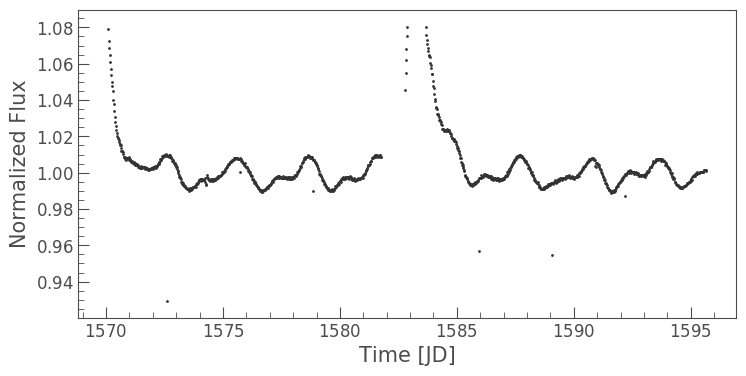

In [12]:
lc = p.lc.remove_outliers(sigma_lower=5)
lc.scatter()

Using period=8.3249 d, epoch=2458574.27 BTJD, duration=1.86 hr
Using biweight filter with window_length=0.23 day


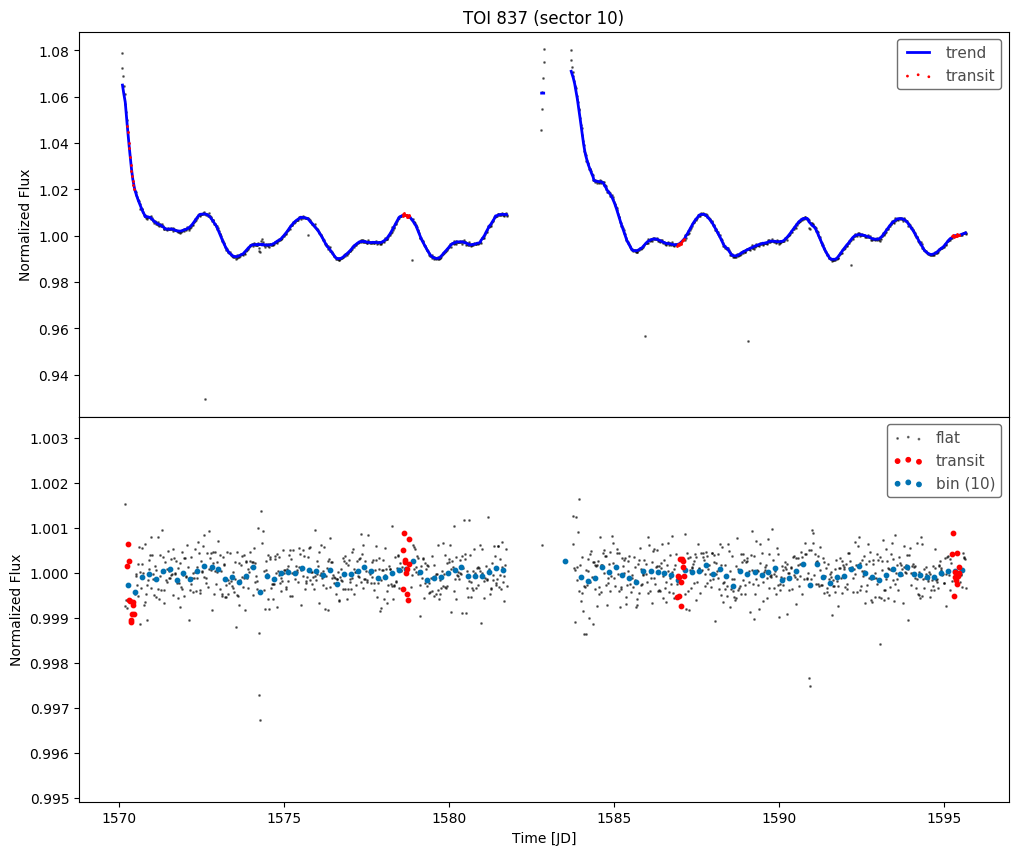

In [13]:
fig = p.plot_trend_flat_lcs(lc,
                            period=p.toi_period,
                            epoch=p.toi_epoch,
                            duration=p.toi_duration
                           )

Using biweight filter with window_length=0.23 day


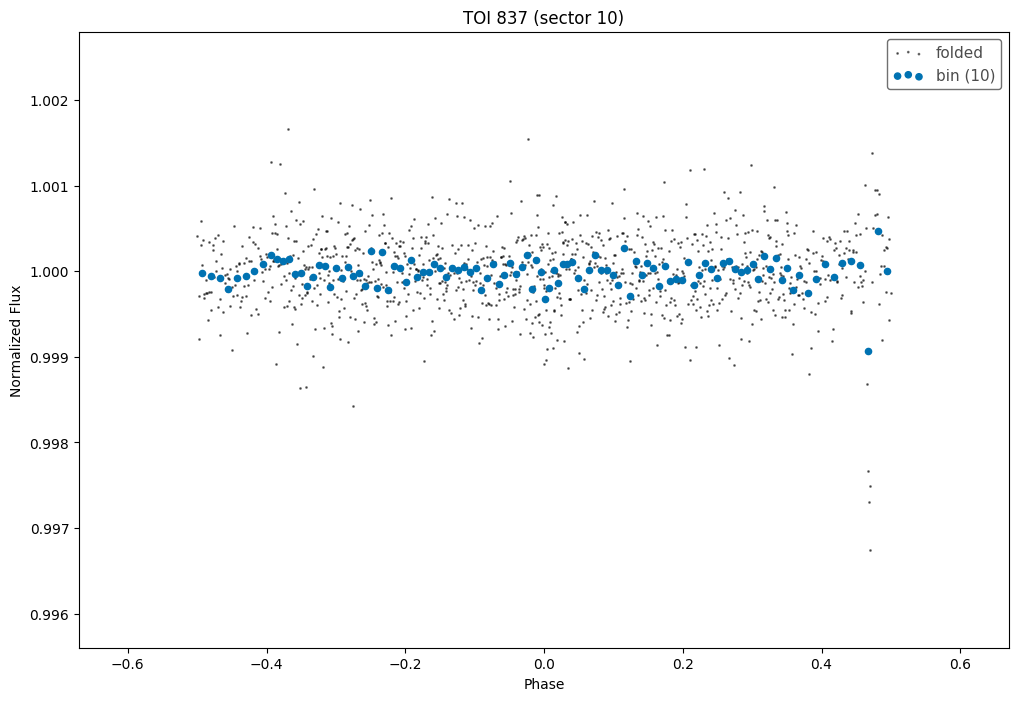

In [14]:
flat = p.get_flat_lc(lc,
                     period=p.toi_period,
                    epoch=p.toi_epoch,
                    duration=p.toi_duration
                    )
fig = p.plot_fold_lc(flat,
                     period=p.toi_period,
                    epoch=p.toi_epoch,
                    duration=p.toi_duration
                    )

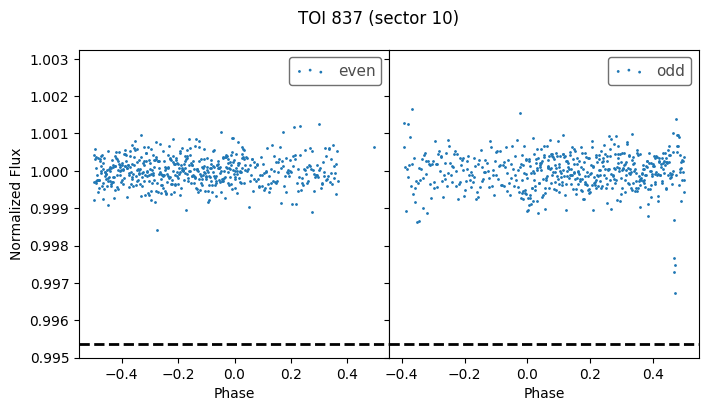

In [15]:
fig = p.plot_odd_even(flat,
                period=p.toi_period,
                    epoch=p.toi_epoch,
               )

## add gof and D

In [ ]:
from tqdm import tqdm

tmags = {}
sectors = {}
gaia_params = {}
for idx,row in tqdm(df.iterrows()):
    ticid = row['TIC ID']
    t = cr.Target(ticid=ticid, verbose=False)
    sectors[ticid] = t.all_sectors
    #tic
    tic_params = t.query_tic_catalog(return_nearest_xmatch=True)
    tmags[ticid] = tic_params.Tmag
    #gaia
    g = t.query_gaia_dr2_catalog(return_nearest_xmatch=True)
    gaia_params[ticid] = g

In [ ]:
gaia_params[ticid].astrometric_gof_al, gaia_params[ticid].astrometric_excess_noise_sig

In [ ]:
mags = {ticid: tmags[ticid] for ticid in tmags}
secs = {ticid: sectors[ticid] for ticid in sectors}
pars = {ticid: gaia_params[ticid].parallax for ticid in gaia_params}
pmras = {ticid: gaia_params[ticid].pmra for ticid in gaia_params}
pmdecs = {ticid: gaia_params[ticid].pmdec for ticid in gaia_params}
gmags = {ticid: gaia_params[ticid].phot_g_mean_mag for ticid in gaia_params}
gof_al = {ticid: gaia_params[ticid].astrometric_gof_al for ticid in gaia_params}
excess_noise_sig = {ticid: gaia_params[ticid].astrometric_excess_noise_sig for ticid in gaia_params}

In [ ]:
import pandas as pd

d = pd.DataFrame([gof_al,excess_noise_sig,mags,secs,gmags,pars,pmras,pmdecs]).T
d = d.reset_index()
d.columns = ['TIC_ID','gof_al','excess_noise_sig', 'Tmag', 'Sectors', 'Gmag', 'Parallax', 'pmra', 'pmdec']

pathos_candidates = pd.merge(left=df,right=d,on='TIC_ID')

In [ ]:
pathos_candidates

In [ ]:
# idx = p.pathos_candidates['Dec. (deg)']>-30
pathos_candidates.to_csv("../chronos/data/pathos_candidates.csv", index=False)

## See also
* examples-lightcurves-tess-cdips.ipynb

Using period=8.3249 d, epoch=2458574.27 BTJD, duration=1.86 hr
Using biweight filter with window_length=0.23 day


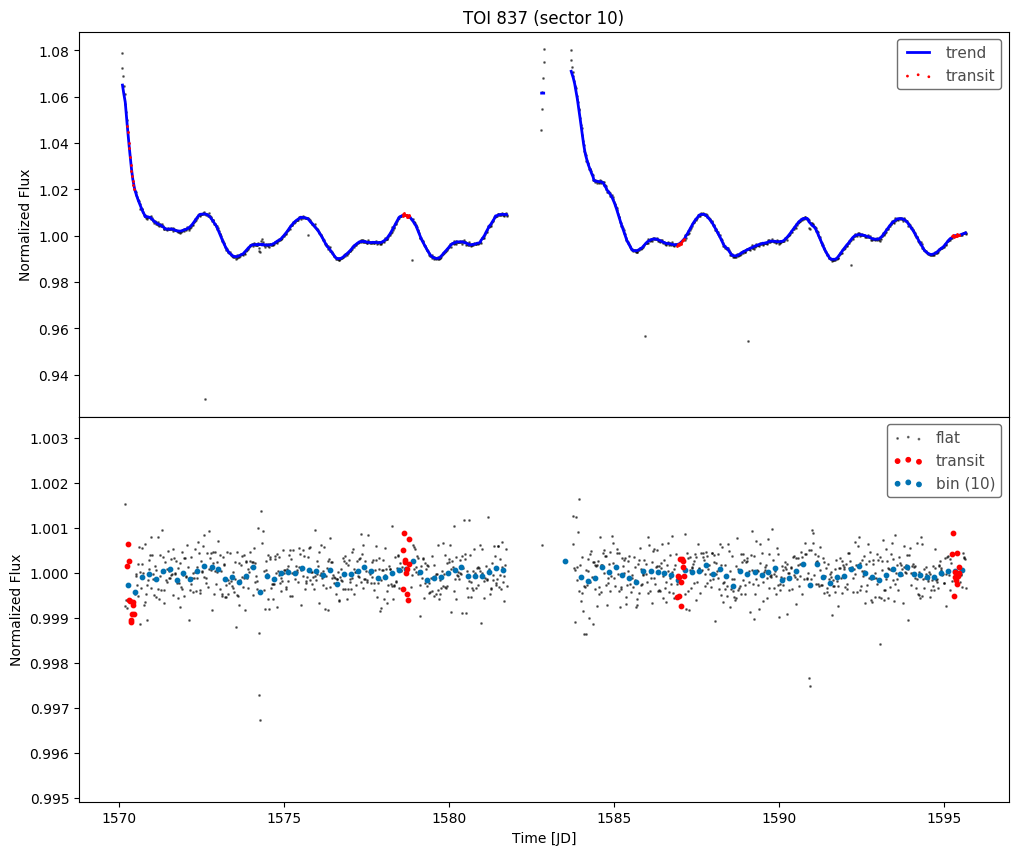

In [19]:
fig = p.plot_trend_flat_lcs(lc,
                            period=p.toi_period,
                            epoch=p.toi_epoch,
                            duration=p.toi_duration
                           )